# Check that blackJAX works

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats

import blackjax

jax.devices()

I0000 00:00:1702584159.672841  548722 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0)]

In [2]:
# Define toy problem
rng_key = jax.random.key(5)

loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000)
def logdensity_fn(loc, log_scale, observed=observed):
    """Univariate Normal"""
    scale = jnp.exp(log_scale)
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return jnp.sum(logpdf)


logdensity = lambda x: logdensity_fn(**x)

In [3]:
# Define transition kernel
inv_mass_matrix = np.array([0.5, 0.01])
num_integration_steps = 60
step_size = 1e-3

hmc = blackjax.hmc(logdensity, step_size, inv_mass_matrix, num_integration_steps)

# Initial state
initial_position = {"loc": 1.0, "log_scale": 1.0}
initial_state = hmc.init(initial_position)
initial_state

In [5]:
# Define inference loop
hmc_kernel = jax.jit(hmc.step)

def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [6]:
%%time
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, hmc_kernel, initial_state, 10_000)

mcmc_samples = states.position
mcmc_samples["scale"] = jnp.exp(mcmc_samples["log_scale"]).block_until_ready()

CPU times: user 1.15 s, sys: 46.8 ms, total: 1.2 s
Wall time: 1.17 s


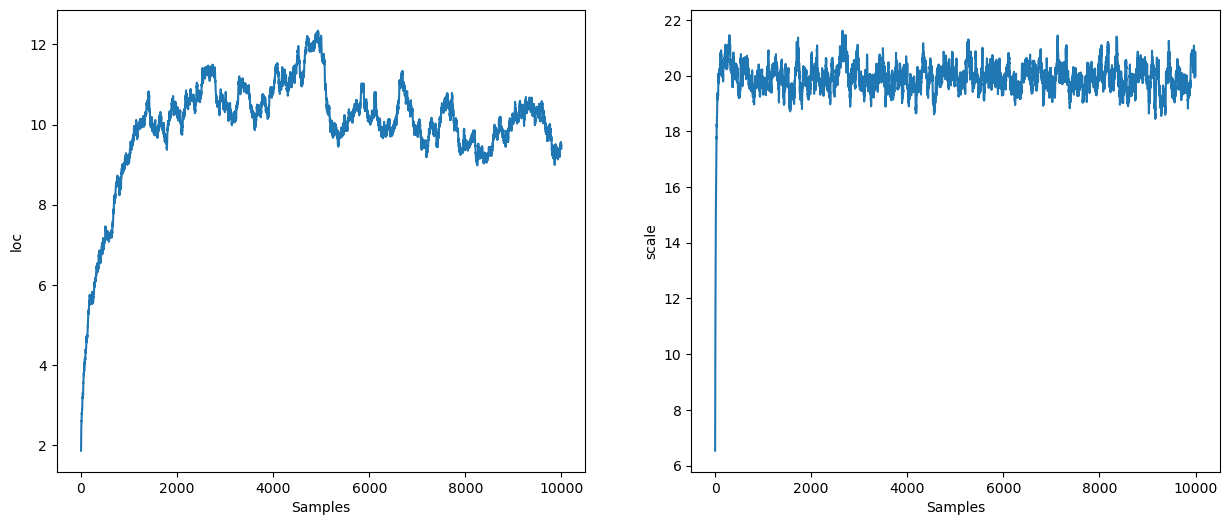

In [7]:
# Confirm that the chain converges
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15, 6))
ax.plot(mcmc_samples["loc"])
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(mcmc_samples["scale"])
ax1.set_xlabel("Samples")
ax1.set_ylabel("scale");